In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from ConvAutoencoder import Encoder, Decoder
from actor_critic import ActorCritic, update, compute_reward
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
# Prepara il dataset con una finestra di 3 stati
window_size = 3

# Dati simulati per esempio
frames = torch.load("frames_sinus.pt")  # Carica il dataset salvato
frames = frames.float() / 255.0  # Normalizza tra [0, 1]
frames = frames.permute(0, 3, 1, 2)  # Cambia dimensione a (N, C, H, W)

# Dimensioni del dataset
#dataset_size = len(frames)
#train_size = int(0.8 * dataset_size)  # 80% per il training
#test_size = dataset_size - train_size  # 20% per il test

########## TOY MODEL ##########
train_size = 500
test_size = 100


# Divisione del dataset preservando l'ordine
train_frames = frames[:train_size]
test_frames = frames[train_size:test_size + train_size]

# DataLoader
batch_size = 8
train_loader = DataLoader(train_frames, batch_size=batch_size, shuffle=False)  # Shuffle disattivato
test_loader = DataLoader(test_frames, batch_size=batch_size, shuffle=False)

# Stampa informazioni
#print(f"Dataset totale: {dataset_size} esempi")
print(f"Training set: {train_size} esempi")
print(f"Test set: {test_size} esempi")

# Parametri
latent_dim = 8192 * window_size # 64x64 pixels per frame
action_dim = 8192  # Dimensione delle azioni
gamma = 0.99
learning_rate = 1e-3

# Modello Actor-Critic
actor_critic = ActorCritic(latent_dim, action_dim, window_size)
optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate)

# Encoder pre-addestrato
encoder = Encoder()
encoder.load_state_dict(torch.load('encoder.pth'))
encoder.eval()

# Training loop
num_epochs = 50
epoch_losses = []
epoch_actor_losses = []
epoch_critic_losses = []
epoch_rewards = []

for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_actor_loss = 0
    epoch_critic_loss = 0
    epoch_reward = 0
    
    for i in range(len(train_frames) - window_size):
        # Seleziona una finestra di immagini
        state_frames = train_frames[i : i + window_size]
        next_frame = train_frames[i + window_size]
        
        # Ottieni la rappresentazione latente
        with torch.no_grad():
            latent_states = torch.stack([encoder(state.unsqueeze(0)) for state in state_frames])
            latent_states = latent_states.view(1, window_size, -1)
            real_next_state = encoder(next_frame.unsqueeze(0)).view(-1)

        loss, actor_loss, critic_loss, reward = update(actor_critic, optimizer, latent_states, real_next_state, gamma)

        # Accumula i risultati per l'epoca
        epoch_loss += loss
        epoch_actor_loss += actor_loss
        epoch_critic_loss += critic_loss
        epoch_reward += reward

    # Salva le medie dell'epoca
    epoch_losses.append(epoch_loss / (len(train_frames) - window_size))
    epoch_actor_losses.append(epoch_actor_loss / (len(train_frames) - window_size))
    epoch_critic_losses.append(epoch_critic_loss / (len(train_frames) - window_size))
    epoch_rewards.append(epoch_reward / (len(train_frames) - window_size))

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Critic_loss: {epoch_critic_loss:.4f}, Actor_loss: {epoch_actor_loss:.4f}, Reward: {epoch_reward:.4f}")


Training set: 500 esempi
Test set: 100 esempi
Epoch 1/50, Loss: 2141.9238, Critic_loss: 1072.6800, Actor_loss: 1069.2437, Reward: -1757.7428
Epoch 2/50, Loss: 101.7779, Critic_loss: 67.1407, Actor_loss: 34.6372, Reward: -1829.8594
Epoch 3/50, Loss: 85.2595, Critic_loss: 63.5068, Actor_loss: 21.7527, Reward: -1504.6799
Epoch 4/50, Loss: 55.7123, Critic_loss: 41.4778, Actor_loss: 14.2345, Reward: -1225.7759
Epoch 5/50, Loss: 25.8256, Critic_loss: 19.1111, Actor_loss: 6.7144, Reward: -1082.1365
Epoch 6/50, Loss: 13.2101, Critic_loss: 9.7475, Actor_loss: 3.4626, Reward: -1013.3537
Epoch 7/50, Loss: 7.4841, Critic_loss: 5.6004, Actor_loss: 1.8837, Reward: -968.3022
Epoch 8/50, Loss: 7.0837, Critic_loss: 4.9126, Actor_loss: 2.1711, Reward: -951.0557
Epoch 9/50, Loss: 9.3067, Critic_loss: 6.5715, Actor_loss: 2.7352, Reward: -920.4059
Epoch 10/50, Loss: 17.7799, Critic_loss: 11.8123, Actor_loss: 5.9676, Reward: -837.3508
Epoch 11/50, Loss: 24.7154, Critic_loss: 16.3989, Actor_loss: 8.3165, Rew

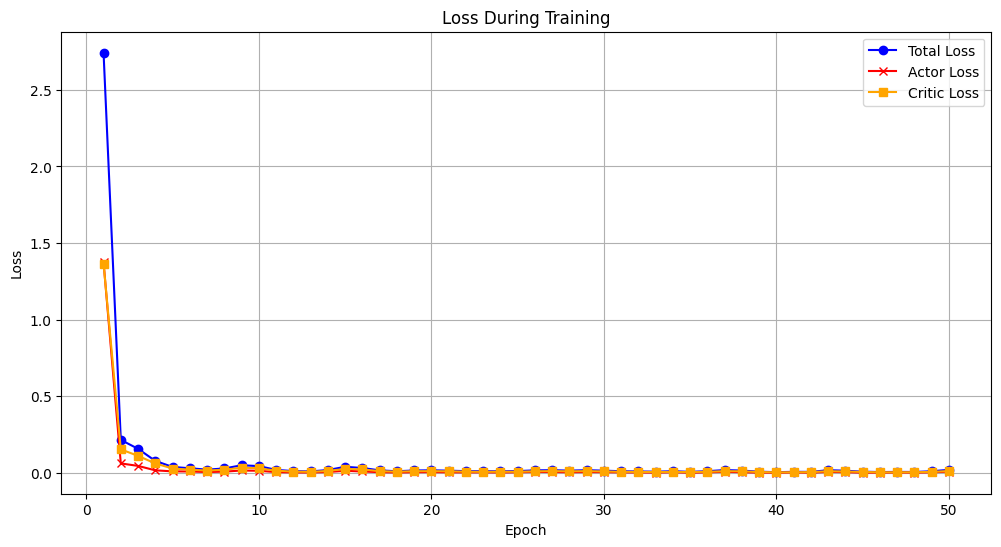

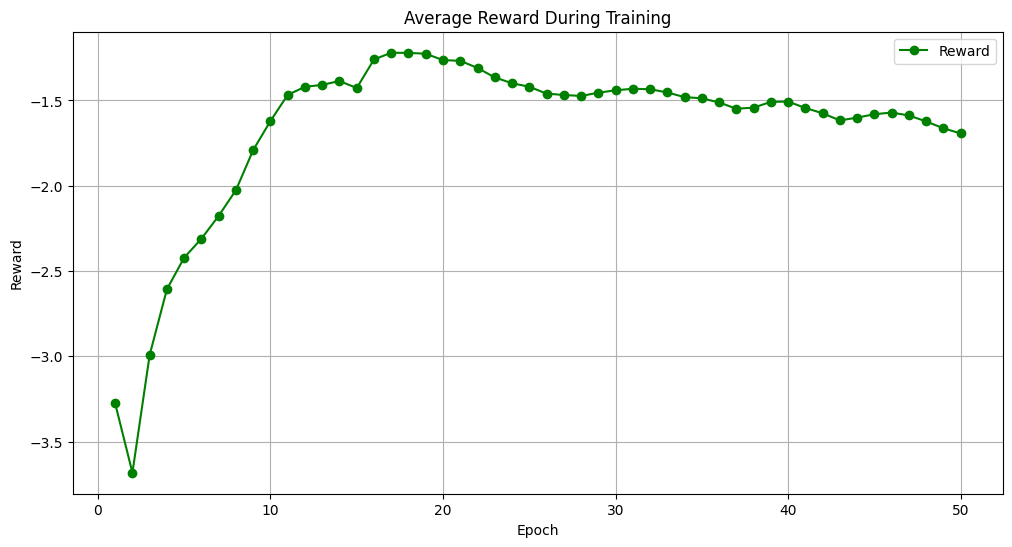

In [3]:
# Grafico delle Loss
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', label='Total Loss', color='blue')
plt.plot(range(1, num_epochs + 1), epoch_actor_losses, marker='x', label='Actor Loss', color='red')
plt.plot(range(1, num_epochs + 1), epoch_critic_losses, marker='s', label='Critic Loss', color='orange')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Grafico dei Reward
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), epoch_rewards, marker='o', label='Reward', color='green')
plt.title('Average Reward During Training')
plt.xlabel('Epoch')
plt.ylabel('Reward')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
# Metti i modelli in modalità valutazione
encoder.eval()
actor_critic.eval()

# Liste per memorizzare le loss
test_losses = []
real_states_list = []
predicted_states_list = []
print(len(test_frames) - window_size)
# Calcola la loss sui dati di test
with torch.no_grad():
    for i in range(len(test_frames) - window_size):
        # Seleziona una finestra di immagini
        state_frames = test_frames[i : i + window_size]
        next_frame = test_frames[i + window_size]

        # Ottieni la rappresentazione latente dalla finestra di immagini
        latent_states = torch.stack([encoder(state.unsqueeze(0)) for state in state_frames])  # [window_size, latent_dim]
        latent_states = latent_states.view(1, window_size, -1)  # Aggiunge dimensione batch [1, window_size, latent_dim]
        real_next_state = encoder(next_frame.unsqueeze(0)).view(-1)  # Stato reale successivo [latent_dim]

        # Predici l'azione e il prossimo stato
        state_sequence = latent_states.view(1, -1)  # Concatena la finestra temporale [1, window_size * latent_dim]
        action, _ = actor_critic(state_sequence)

        last_state = latent_states[:, -1, :]  # Ottieni l'ultimo stato della finestra [1, latent_dim]
        predicted_next_state = last_state.squeeze(0) + action.squeeze(0)  # Stato predetto [latent_dim]

        # Calcola la perdita (MSE)
        loss = F.mse_loss(predicted_next_state, real_next_state, reduction='mean')
        test_losses.append(loss.item())

        # Salva i primi 5 esempi
        if (i == 20 or i == 40 or i == 60 or i == 80 or i == 0):
            real_states_list.append(real_next_state.cpu().numpy())
            predicted_states_list.append(predicted_next_state.cpu().numpy())

# Calcola la perdita media
mean_test_loss = sum(test_losses) / len(test_losses)
print(f"Mean Test Loss: {mean_test_loss:.4f}")


2
Mean Test Loss: 0.0001


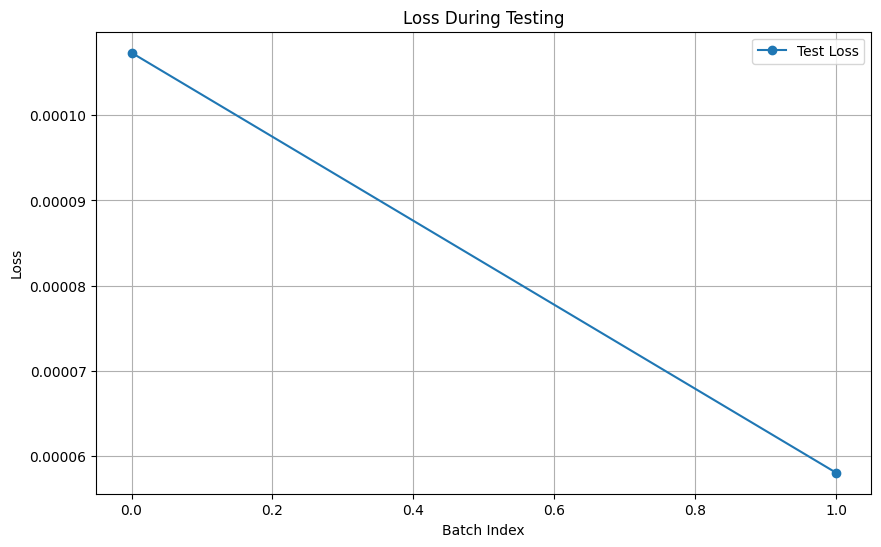

In [7]:
# Plotta la loss durante il test
plt.figure(figsize=(10, 6))
plt.plot(range(len(test_losses)), test_losses, marker='o', label='Test Loss')
plt.title('Loss During Testing')
plt.xlabel('Batch Index')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Modello Decoder
decoder = Decoder()

# Carica i pesi salvati
decoder.load_state_dict(torch.load('decoder.pth'))

decoder.eval()  # Usa l'encoder pre-addestrato

Decoder(
  (up1): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (up2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (up3): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)

Real States List:  [array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)]
5 5


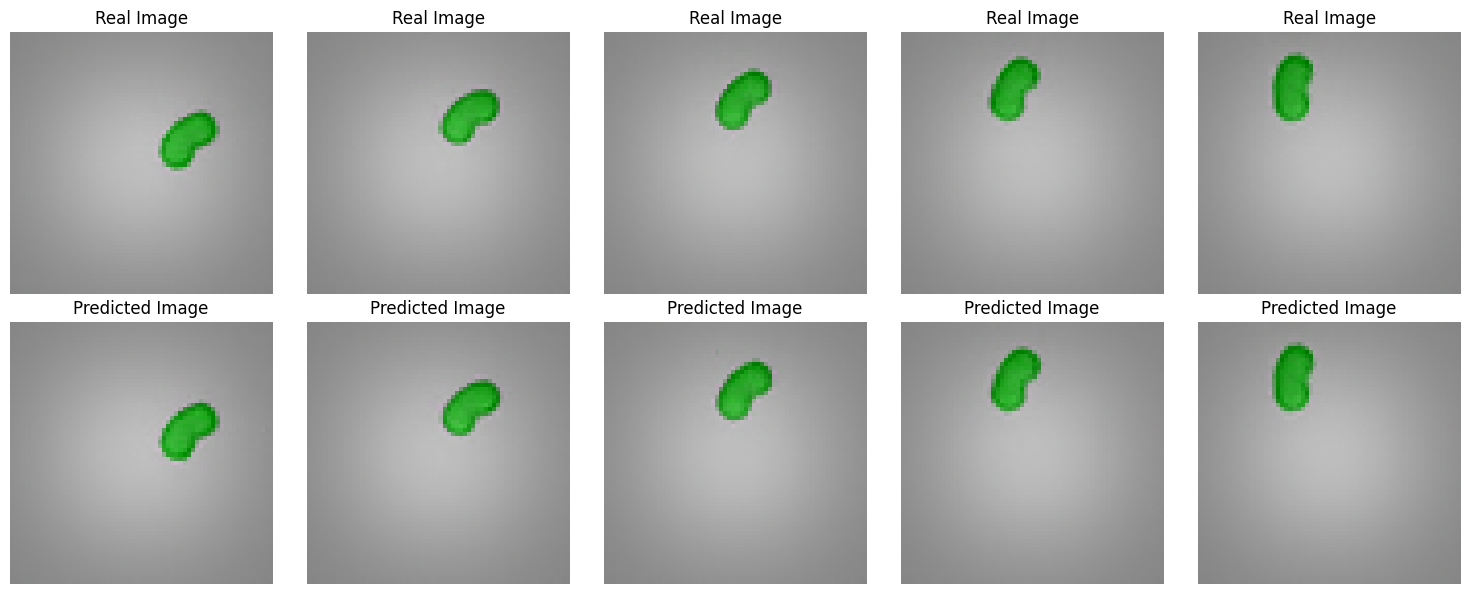

In [7]:
# Visualizza 5 esempi di stati reali e predetti, decodificati dal decoder
plt.figure(figsize=(15, 6))
print("Real States List: ", real_states_list)
print(len(real_states_list), len(predicted_states_list))
num_examples = min(len(real_states_list), len(predicted_states_list), 5)  # Limita il numero di esempi

for i in range(num_examples):
    # Decodifica lo stato reale
    real_state = torch.tensor(real_states_list[i]).unsqueeze(0)  # (1, 8192)
    real_state = real_state.view(1, 128, 8, 8)  # Rimodella in (batch_size, channels, height, width)
    real_image = decoder(real_state).detach().squeeze(0).permute(1, 2, 0).cpu().numpy()  # Aggiunto detach()
    real_image = (real_image * 255).astype('uint8')  # Rimuove la normalizzazione per visualizzazione

    # Decodifica lo stato predetto
    predicted_state = torch.tensor(predicted_states_list[i]).unsqueeze(0)  # (1, 8192)
    predicted_state = predicted_state.view(1, 128, 8, 8)  # Rimodella in (batch_size, channels, height, width)
    predicted_image = decoder(predicted_state).detach().squeeze(0).permute(1, 2, 0).cpu().numpy()  # Aggiunto detach()
    predicted_image = (predicted_image * 255).astype('uint8')  # Rimuove la normalizzazione per visualizzazione

    # Plotta l'immagine reale
    plt.subplot(2, 5, i + 1)
    plt.imshow(real_image)
    plt.title("Real Image")
    plt.axis('off')

    # Plotta l'immagine predetta
    plt.subplot(2, 5, i + 6)
    plt.imshow(predicted_image)
    plt.title("Predicted Image")
    plt.axis('off')

plt.tight_layout()
plt.show()
